In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt

In [19]:
tf.random.set_seed(23)

In [20]:
tf.keras.backend.clear_session()

In [21]:
# Cargar y Preprocesar el Dataset
dataset_dir = "../datasets_insectos"
image_size = (224, 224)  # MobileNetV3 espera imágenes de 224x224
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=True,
    follow_links=False,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "val"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=False,
)

# Obtener los nombres de las clases (ordenados por el directorio)
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Clases detectadas: {class_names}")
print(f"Número de clases: {num_classes}")


Found 641 files belonging to 5 classes.
Found 78 files belonging to 5 classes.
Found 85 files belonging to 5 classes.
Clases detectadas: ['arana-mona', 'bachaco', 'bachaco-culon', 'libelula', 'saltamontes']
Número de clases: 5


In [22]:
# Configurar el aumento de datos (Data Augmentation)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        # Puedes añadir más capas de aumento de datos aquí
    ],
    name="data_augmentation",
)

In [23]:
# Aplicar aumento solo al conjunto de entrenamiento
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [24]:
# Optimizar el rendimiento de la carga de datos
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
# Cargar MobileNetV3
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=image_size + (3,),
    include_top=False,
    weights='imagenet',
)

base_model.trainable = False  # No actualizar capas inferiores en las primeras épocas

In [26]:
inputs = keras.Input(shape=image_size + (3,))
x = inputs

# Construir modelo de fine-tuning
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Capa de dropout para regularización
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 5)                 4805      
                                                                 
Total params: 3001157 (11.45 MB)
Trainable params: 4805 (18.7

In [27]:
# Definir el Early Stopping
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1,
)

In [28]:
epochs_initial = 10
print(f"\nEntrenando las capas superiores por {epochs_initial} épocas...")
history_initial = model.fit(
    train_ds,
    epochs=epochs_initial,
    validation_data=val_ds,
    callbacks=[early_stopping_callback],
)


Entrenando las capas superiores por 10 épocas...
Epoch 1/10
41/41 [==============================] - 15s 281ms/step - loss: 0.9625 - accuracy: 0.6521 - val_loss: 0.4848 - val_accuracy: 0.8333
Epoch 2/10
41/41 [==============================] - 6s 158ms/step - loss: 0.3349 - accuracy: 0.8939 - val_loss: 0.3679 - val_accuracy: 0.8590
Epoch 3/10
41/41 [==============================] - 7s 160ms/step - loss: 0.2158 - accuracy: 0.9267 - val_loss: 0.3107 - val_accuracy: 0.8846
Epoch 4/10
41/41 [==============================] - 7s 169ms/step - loss: 0.1678 - accuracy: 0.9516 - val_loss: 0.2889 - val_accuracy: 0.8846
Epoch 5/10
41/41 [==============================] - 8s 200ms/step - loss: 0.1306 - accuracy: 0.9610 - val_loss: 0.2777 - val_accuracy: 0.8846
Epoch 6/10
41/41 [==============================] - 9s 216ms/step - loss: 0.1156 - accuracy: 0.9735 - val_loss: 0.2614 - val_accuracy: 0.9103
Epoch 7/10
41/41 [==============================] - 9s 210ms/step - loss: 0.0873 - accuracy: 0.97

In [29]:
base_model.trainable = True

# Congelar capas de Batch Normalization (BN)
# Es una práctica común dejar las capas de Batch Normalization congeladas durante el fine-tuning,
# ya que sus estadísticas pueden volverse inestables con tamaños de batch pequeños.
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# Recompilar el modelo con un learning rate más bajo
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-5
    ),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 5)                 4805      
                                                                 
Total params: 3001157 (11.45 MB)
Trainable params: 2952357 (1

In [30]:
epochs_fine_tune = 10  # Más épocas para el fine-tuning profundo
total_epochs = epochs_initial + epochs_fine_tune

print(
    f"\nContinuando el entrenamiento (fine-tuning profundo) por {epochs_fine_tune} épocas..."
)
history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history_initial.epoch[-1] + 1,
    validation_data=val_ds,
    callbacks=[early_stopping_callback],
)


Continuando el entrenamiento (fine-tuning profundo) por 10 épocas...
Epoch 11/20
41/41 [==============================] - 32s 562ms/step - loss: 0.0417 - accuracy: 0.9922 - val_loss: 0.2346 - val_accuracy: 0.9359
Epoch 12/20
41/41 [==============================] - 25s 602ms/step - loss: 0.0255 - accuracy: 0.9969 - val_loss: 0.2368 - val_accuracy: 0.9359
Epoch 13/20
41/41 [==============================] - 26s 637ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.2418 - val_accuracy: 0.9359
Epoch 14/20
41/41 [==============================] - 27s 670ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.2316 - val_accuracy: 0.9359
Epoch 15/20
41/41 [==============================] - 27s 655ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.2193 - val_accuracy: 0.9359
Epoch 16/20
41/41 [==============================] - 28s 692ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.2320 - val_accuracy: 0.9359
Epoch 17/20
41/41 [==============================] - 28s 677ms/ste

In [31]:
# --- 8. Evaluar el Modelo ---
loss, accuracy = model.evaluate(test_ds)
print(f"\nPrecisión en el conjunto de prueba: {accuracy * 100:.2f}%")


6/6 [==============================] - 2s 220ms/step - loss: 0.1099 - accuracy: 0.9529

Precisión en el conjunto de prueba: 95.29%


In [32]:
# --- 9. Guardar el Modelo ---
model.save("mobilenet_v3_insectos_fine_tuned_model.h5")

c:\Users\Gabriel Mendez\Documents\UCAB\8vo Semestre\Inteligencia Artificial\llovizna-ai\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


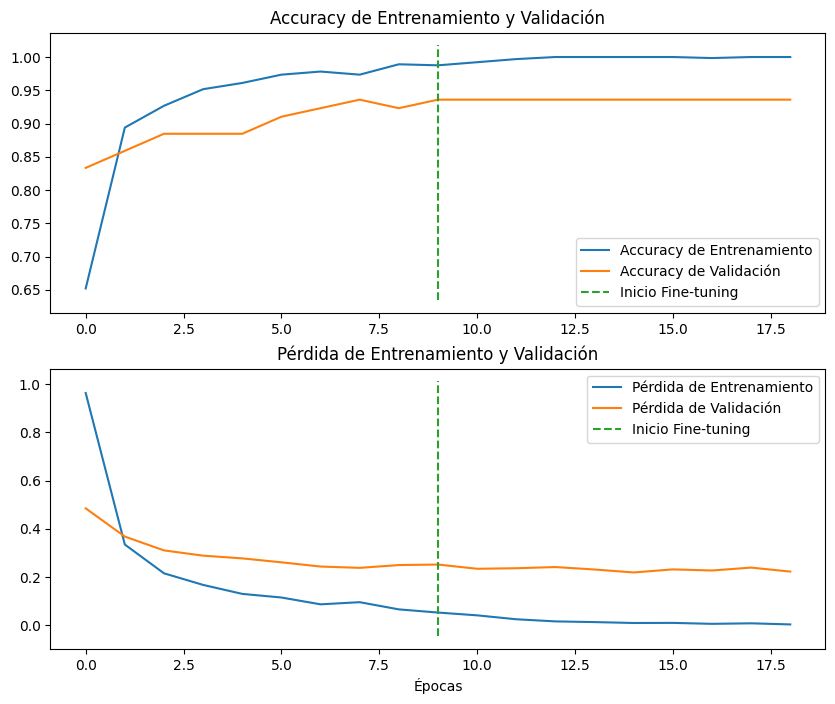

In [33]:
# --- 10. Visualizar el Historial de Entrenamiento ---
def plot_history(history_initial, history_fine_tune):
    acc = history_initial.history["accuracy"] + history_fine_tune.history["accuracy"]
    val_acc = (
        history_initial.history["val_accuracy"]
        + history_fine_tune.history["val_accuracy"]
    )
    loss = history_initial.history["loss"] + history_fine_tune.history["loss"]
    val_loss = (
        history_initial.history["val_loss"] + history_fine_tune.history["val_loss"]
    )

    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label="Accuracy de Entrenamiento")
    plt.plot(val_acc, label="Accuracy de Validación")
    plt.plot(
        [epochs_initial - 1, epochs_initial - 1],
        plt.ylim(),
        label="Inicio Fine-tuning",
        linestyle="--",
    )
    plt.legend(loc="lower right")
    plt.title("Accuracy de Entrenamiento y Validación")

    plt.subplot(2, 1, 2)
    plt.plot(loss, label="Pérdida de Entrenamiento")
    plt.plot(val_loss, label="Pérdida de Validación")
    plt.plot(
        [epochs_initial - 1, epochs_initial - 1],
        plt.ylim(),
        label="Inicio Fine-tuning",
        linestyle="--",
    )
    plt.legend(loc="upper right")
    plt.title("Pérdida de Entrenamiento y Validación")
    plt.xlabel("Épocas")
    plt.show()


plot_history(history_initial, history_fine_tune)


1/1 [==============================] - 0s 100ms/step


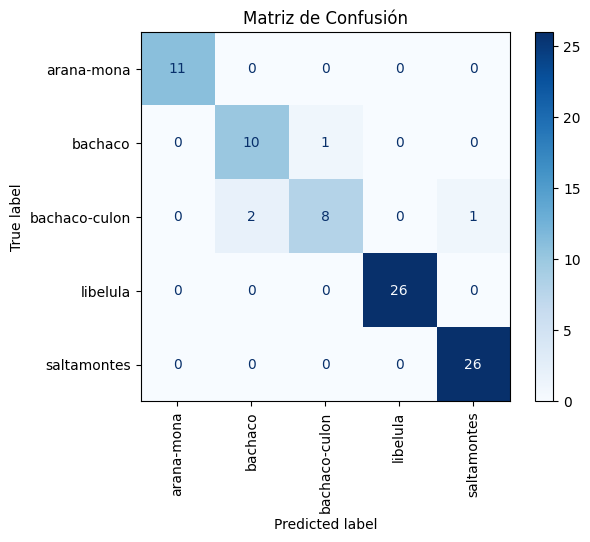

In [34]:
# Ver matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(model, test_ds):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.argmax(axis=1))

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusión")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.xticks(rotation=90)
    plt.show()

plot_confusion_matrix(model, test_ds)